# Readout dynamics of two-PF setup with quantum jump method

In [1]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt

plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=26

In [2]:
# Definition of constants
phi = np.arctan(1/np.sqrt(27)) ### Phase of the PF coupling
lam = 2.4e3*2*np.pi ### Angular frequency measure in units of 1/{\mu}s
eps = lam ### PF overlap energy
Gam = lam/10  ### Measurement rate between lead and PF 1
beta = (3/lam) ### Inverse temperature
tL = 1j*np.sqrt(Gam) ### Amplitude of the jump operators
tres = 1e-2 ### Resolution time in units of {\mu}s
dt =1e-4 ### Time step in units of {\mu}s
tb= 1e-1 ### The integration time in units of {\mu}s (t_avg in article) 
tGam=(2*np.pi)/Gam ### The inverse of the measurement rate in units of {\mu}s
Nshort =round(tres/dt) ### Number of time steps in the "short time" simulation
Nlong=Nshort*50 ### ... "long time" simulation
Navg=round(tb/dt) ### The number time steps averaged over for finding the current
Vmax=7*lam ### Half width of voltage range
NV=900 ### Number that sets the resolution in voltage

In [3]:
qO = np.diag([0.,1,2,0,1,2]) ### The \tilde{q} operator
Hpf = np.diag([-2*eps*np.cos(np.pi*q/3 + phi) for q in range (6)]) ### The 2PF Hamiltonian
Xi0=4*eps*np.cos(phi)
Xi1=4*eps*np.cos(np.pi/3+phi)
Xi2=4*eps*np.cos(np.pi*2/3+phi)

In [4]:
q03 = np.array([1./np.sqrt(2),0,0,1./np.sqrt(2),0,0], dtype=complex) ### States with a well-defined \tilde{q}=0
q14 = np.array([0.,1./np.sqrt(2),0,0,1./np.sqrt(2),0], dtype=complex) ### ... \tilde{q}=1
q25 = np.array([0.,0,1./np.sqrt(2),0,0,1./np.sqrt(2)], dtype=complex) ### ... \tilde{q}=2
qsimple=np.array([1./np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3),0,0,0], dtype=complex) ### The simple superposition used for appendix figure
qeq =np.array([1./np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6)], dtype=complex) ### The "worst case" superposition

In [5]:
def L1(V): ### Here we define the jump operator L+ as a function of voltage
    L1_ret = np.zeros((6,6), dtype=complex)
    L1_ret[0, 3] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(phi)-V)))) ### Here we enter manually the elements of the jump matrix
    L1_ret[1, 4] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi/3+phi)-V))))
    L1_ret[2, 5] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*2/3+phi)-V))))
    L1_ret[3, 0] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*3/3+phi)-V))))
    L1_ret[4, 1] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*4/3+phi)-V))))
    L1_ret[5, 2] = tL*np.sqrt(1/(1+np.exp(beta*(-4*eps*np.cos(np.pi*5/3+phi)-V))))
    return L1_ret

In [6]:
def L2(V): ### Here we define the jump operator L- as a function of voltage
    L2_ret = np.zeros((6,6), dtype=complex) 
    L2_ret[0, 3] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(phi)-V)))) ### Here we enter manually the elements of the jump matrix
    L2_ret[1, 4] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi/3+phi)-V))))
    L2_ret[2, 5] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*2/3+phi)-V))))
    L2_ret[3, 0] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*3/3+phi)-V))))
    L2_ret[4, 1] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*4/3+phi)-V))))
    L2_ret[5, 2] = tL*np.sqrt(1-1/(1+np.exp(beta*(4*eps*np.cos(np.pi*5/3+phi)-V))))
    return L2_ret

In [7]:
def U(V): ### Here we define the no-jump evolution operator
    U_ret = sla.expm((-1j*dt)*(Hpf-1j*((L1(V).T.conj())@L1(V)+(L2(V).T.conj())@L2(V))/2))
    return U_ret

## Superposition, short times

In [8]:
sttabeqsh=[]
for k in range(NV+1):
    steqsh=[qeq]
    st = qsimple
    Umat=U(-Vmax+k*2*Vmax/NV)
    L1mat=L1(-Vmax+k*2*Vmax/NV)
    L2mat=L2(-Vmax+k*2*Vmax/NV)
    for i in range(1,Nshort+1):
        stnj = Umat@st
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = L1mat@stnjR
        L2st = L2mat@stnjR
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                else:
                    st=stnjR
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                else:
                    st=stnjR
        steqsh.append(st)
    sttabeqsh.append(steqsh)
    
starreqsh=np.array(sttabeqsh)

In [9]:
tpsh=[]
for k in range(NV+1):
    stk=starreqsh[k,:,:]
    for i in range(Nshort+1):
        c=((stk[i,0].conj())*stk[i,0]+(stk[i,3].conj())*stk[i,3])**2+((stk[i,1].conj())*stk[i,1]+(stk[i,4].conj())*stk[i,4])**2+((stk[i,2].conj())*stk[i,2]+(stk[i,5].conj())*stk[i,5])**2
        if c>0.9:
            break
    tpsh.append(i*dt)    

tparrsh=np.array(tpsh)

In [10]:
qtabeqsh=[]
for k in range(NV+1):
    qeqsh=[]
    vol=-Vmax+k*2*Vmax/NV
    for i in range(Nshort+1):
        qsh = np.array([vol,i*dt,np.vdot(starreqsh[k,i],(qO@starreqsh[k,i]))])
        qeqsh.append(qsh)
    qtabeqsh.append(qeqsh)
    
qarreqsh=np.real_if_close(qtabeqsh)

In [11]:
veqsh=qarreqsh[:,:,0]
teqsh=qarreqsh[:,:,1]
qeqsh=qarreqsh[:,:,2]

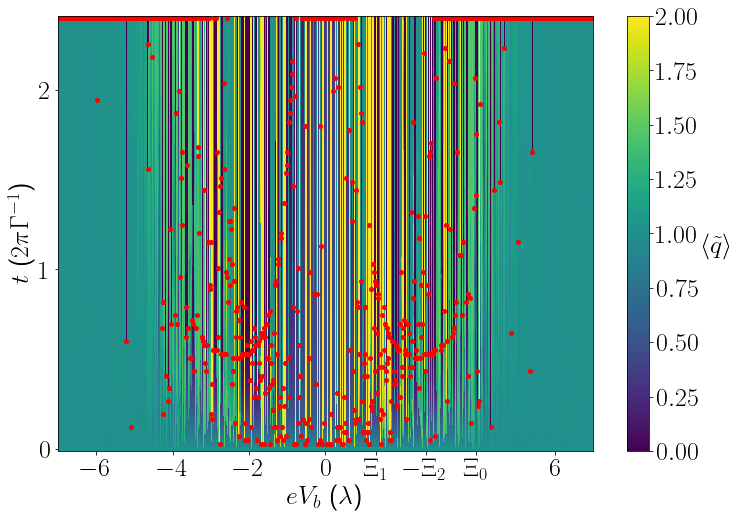

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_xticks(np.array([-6*lam,-4*lam,-2*lam,0,6*lam,Xi0,Xi1,-Xi2]), labels=['$-6$','$-4$','$-2$', '$0$', '$6$','$\Xi_0$','$\Xi_1$','$-\Xi_2$'])
ax.set_yticks(np.array([0,tGam,2*tGam]), labels=['$0$', '$1$', '$2$'])
plt.pcolormesh(veqsh, teqsh, qeqsh, vmin=0, vmax=2)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$\langle \tilde{q} \rangle$', labelpad=20, loc='center',rotation=0)
v_ax=np.linspace(-Vmax,Vmax,NV+1)
plt.plot(v_ax,tparrsh,'.', color='red', ms=8)
plt.show()

In [13]:
qavgsh=[0,0,0]
for k in range(NV+1):
    if qeqsh[k,-1] <0.66:
        qavgsh=np.add(qavgsh,[1/NV,0,0])
    elif 0.66 < qeqsh[k,-1] < 1.33:
        qavgsh=np.add(qavgsh,[0,1/NV,0])
    elif 1.33 < qeqsh[k,-1]:
        qavgsh=np.add(qavgsh,[0,0,1/NV])
    else:
        qavgsh=np.add(qavgsh,[0,0,0])
        
print(qavgsh)

[0.23111111 0.53111111 0.23888889]


## Superposition, long times

In [14]:
sttabeqlo=[]
Jtab=[]
for k in range(NV+1):
    steqlo=[qeq]
    st = qeq
    Umat=U(-Vmax+k*2*Vmax/NV)
    L1mat=L1(-Vmax+k*2*Vmax/NV)
    L2mat=L2(-Vmax+k*2*Vmax/NV)
    Jdiff=[]
    j1=0
    j2=0
    for i in range(1,Nlong+1):
        stnj = Umat@st
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = L1mat@stnjR
        L2st = L2mat@stnjR
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1+0
                    j2=j2+1
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2+0
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        steqlo.append(st)
        Jdiff.append(j1-j2)
    sttabeqlo.append(steqlo)
    Jtab.append(Jdiff)
    
starreqlo=np.array(sttabeqlo)
Jarrlo=np.array(Jtab)

In [15]:
tplo=[]
for k in range(NV+1):
    stk=starreqlo[k,:,:]
    for i in range(Nlong+1):
        c=((stk[i,0].conj())*stk[i,0]+(stk[i,3].conj())*stk[i,3])**2+((stk[i,1].conj())*stk[i,1]+(stk[i,4].conj())*stk[i,4])**2+((stk[i,2].conj())*stk[i,2]+(stk[i,5].conj())*stk[i,5])**2
        if c>0.9:
            break
    tplo.append(i*dt)    

tparrlo=np.array(tplo)

In [16]:
qtabeqlo=[]
for k in range(NV+1):
    qeqlo=[]
    stlo=starreqlo[k,:]
    for i in range(Nlong+1):
        qlo = np.vdot(stlo[i],(qO@stlo[i]))
        qeqlo.append(qlo)
    qtabeqlo.append(qeqlo)
    
qarreqlo=np.real_if_close(qtabeqlo)

In [17]:
ttab=np.linspace(0,dt*Nlong,Nlong+1)
vol_ax=np.linspace(-Vmax,Vmax,NV+1)
vol_ax_red=np.linspace(-6.86*lam,6.86*lam,NV)

In [18]:
def tstar(V):
    return (2e-3)/((np.exp(-beta*Xi3)+np.cosh(beta*V))/(np.cosh(beta*Xi3)+np.cosh(beta*V))-(np.exp(-beta*Xi2)+np.cosh(beta*V))/(np.cosh(beta*Xi2)+np.cosh(beta*V)))

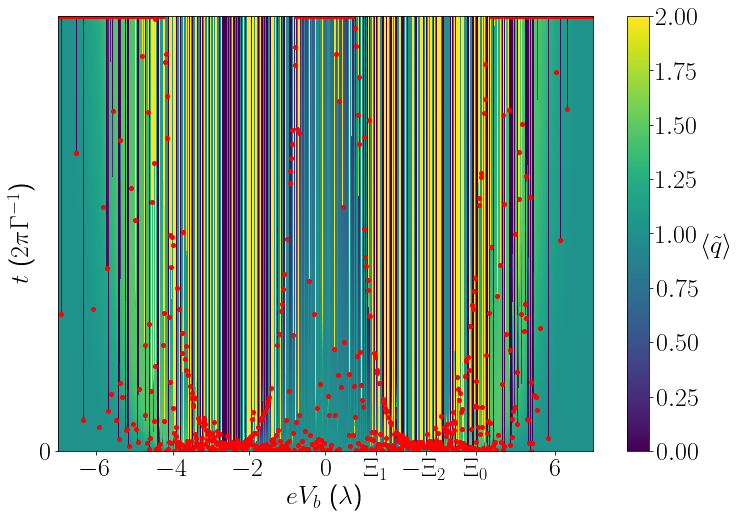

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_xticks(np.array([-6*lam,-4*lam,-2*lam,0,6*lam,Xi0,Xi1,-Xi2]), labels=['$-6$','$-4$','$-2$','$0$', '$6$','$\Xi_0$','$\Xi_1$','$-\Xi_2$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vol_ax, ttab, qarreqlo.T, vmin=0, vmax=2)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$\langle \tilde{q}\rangle$', labelpad=20, loc='center',rotation=0)
plt.plot(vol_ax,tparrlo, '.', color='r', ms=8)
plt.show()

In [26]:
qavglo=[0,0,0]
for k in range(NV+1):
    if qarreqlo[k,-1] <0.66:   
        qavglo=np.add(qavglo,[1/(NV+1),0,0])
    elif 0.66 < qarreqlo[k,-1] < 1.33:
        qavglo=np.add(qavglo,[0,1/(NV+1),0])
    elif 1.33 < qarreqlo[k,-1]: 
        qavglo=np.add(qavglo,[0,0,1/(NV+1)])
    else:
        qavglo=np.add(qavglo,[0,0,0])
        
print(qavglo)

[0.27302997 0.41620422 0.31076582]


In [27]:
Itab=[]
for k in range(NV+1):
    I=[]
    vol=-Vmax+k*2*Vmax/NV
    for i in range(Navg, Nlong):
        curr=1e12*1.6e-19*(Jarrlo[k,i]-Jarrlo[k,i-Navg])/(tb*1e-6)
        I.append(curr)
    Itab.append(I)
    
Iarrlo=np.array(Itab)

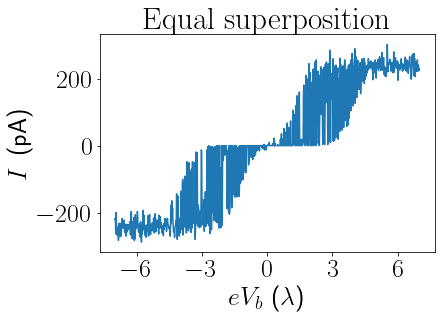

In [28]:
fig, ax = plt.subplots()
vtab=np.linspace(-Vmax,Vmax,NV+1)
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$I$\, (pA)')
ax.set_title(r'\rm Equal superposition')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
plt.plot(vtab,Iarrlo[:,-1])
plt.show()

## Eigenstates of \tilde{q} and H_{2pf}

In [29]:
vtab=np.linspace(-Vmax,Vmax,NV+1)
ttab=np.linspace(0,dt*Nlong,Nlong+1)
ttab_red=np.linspace(tb,Nlong*dt,Nlong-Navg)

In [30]:
qtab0=[]
Jtab0=[]
for k in range(NV+1):
    st = q03
    qtildetab=[np.vdot(st,(qO@st))]
    vb=-Vmax+k*2*Vmax/NV
    Umat=U(vb)
    L1mat=L1(vb)
    L2mat=L2(vb)
    Jdiff=[]
    j1=0
    j2=0
    for i in range(1,Nlong+1):
        stnj = Umat@st
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = L1mat@stnjR
        L2st = L2mat@stnjR
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1+0
                    j2=j2+1
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2+0
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        qtilde=np.vdot(st,(qO@st))
        qtildetab.append(qtilde)
        Jdiff.append(j1-j2)
    qtab0.append(qtildetab)
    Jtab0.append(Jdiff)

In [87]:
qarr0=np.real_if_close(qtab0)

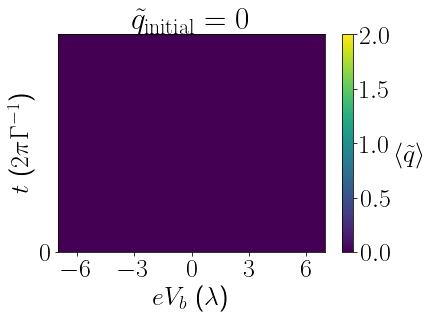

In [93]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=0$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab, qarr0.T, vmin=0, vmax=2)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$\langle \tilde{q} \rangle$', labelpad=20, loc='center',rotation=0)
plt.show()

In [100]:
Jarr0=np.array(Jtab0)
Itab0=[]
for k in range(NV+1):
    I=[]
    vol=-Vmax+k*2*Vmax/NV
    for i in range(Navg, Nlong):
        curr=1e12*1.6e-19*(Jarr0[k,i]-Jarr0[k,i-Navg])/(tb*1e-6)
        I.append(curr)
    Itab0.append(I)
    
Iarr0=np.array(Itab0)

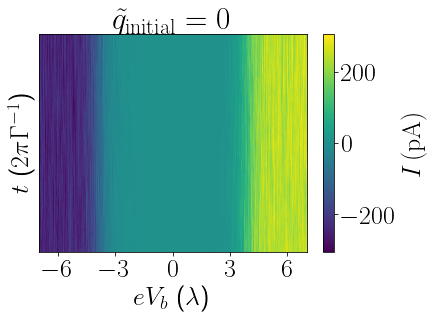

In [104]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=0$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab_red, Iarr0.T)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$I\, (\rm pA)$')
plt.show()

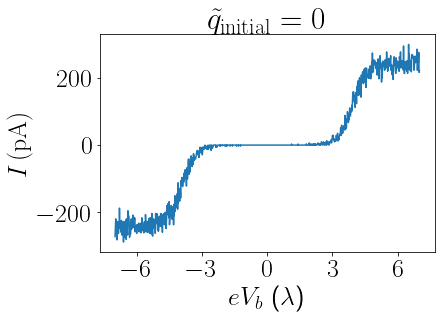

In [107]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$I\, (\rm pA)$')
ax.set_title(r'$\tilde{q}_{\rm initial}=0$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
plt.plot(vtab,Iarr0[:,-1])
plt.show()

In [109]:
qtab1=[]
Jtab1=[]
for k in range(NV+1):
    st = q14
    qtildetab=[np.vdot(st,(qO@st))]
    vb=-Vmax+k*2*Vmax/NV
    Umat=U(vb)
    L1mat=L1(vb)
    L2mat=L2(vb)
    Jdiff=[]
    j1=0
    j2=0
    for i in range(1,Nlong+1):
        stnj = Umat@st
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = L1mat@stnjR
        L2st = L2mat@stnjR
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1+0
                    j2=j2+1
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2+0
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        qtilde=np.vdot(st,(qO@st))
        qtildetab.append(qtilde)
        Jdiff.append(j1-j2)
    qtab1.append(qtildetab)
    Jtab1.append(Jdiff)

In [110]:
qarr1=np.real_if_close(qtab1)

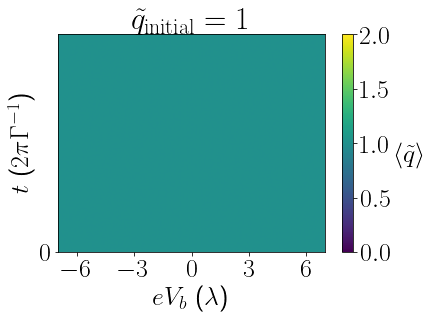

In [111]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=1$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab, qarr1.T, vmin=0, vmax=2)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$\langle \tilde{q} \rangle$', labelpad=20, loc='center',rotation=0)
plt.show()

In [116]:
Jarr1=np.array(Jtab1)
Itab1=[]
for k in range(NV+1):
    I=[]
    vol=-Vmax+k*2*Vmax/NV
    for i in range(Navg, Nlong):
        curr=1e12*1.6e-19*(Jarr1[k,i]-Jarr1[k,i-Navg])/(tb*1e-6)
        I.append(curr)
    Itab1.append(I)
    
Iarr1=np.array(Itab1)

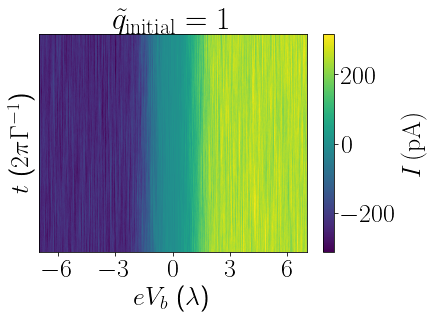

In [117]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=1$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab_red, Iarr1.T)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$I\, (\rm pA)$')
plt.show()

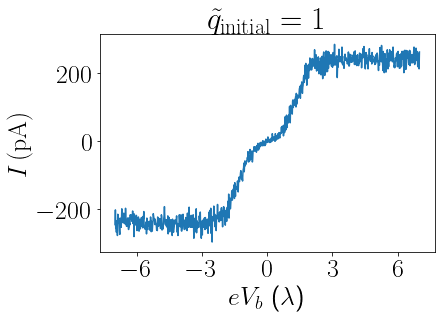

In [118]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$I\, (\rm pA)$')
ax.set_title(r'$\tilde{q}_{\rm initial}=1$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
plt.plot(vtab,Iarr1[:,-1])
plt.show()

In [119]:
qtab2=[]
Jtab2=[]
for k in range(NV+1):
    st = q25
    qtildetab=[np.vdot(st,(qO@st))]
    vb=-Vmax+k*2*Vmax/NV
    Umat=U(vb)
    L1mat=L1(vb)
    L2mat=L2(vb)
    Jdiff=[]
    j1=0
    j2=0
    for i in range(1,Nlong+1):
        stnj = Umat@st
        stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
        L1st = L1mat@stnjR
        L2st = L2mat@stnjR
        Pj1 = dt*(np.vdot(L1st,L1st)).real
        Pj2 = dt*(np.vdot(L2st,L2st)).real
        P=np.random.uniform()
        P1=np.random.uniform()
        P2=np.random.uniform()
        if P<0.5:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                if P2<Pj2:
                    st=L2st/np.sqrt(Pj2/dt)
                    j1=j1+0
                    j2=j2+1
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                if P1<Pj1:
                    st=L1st/np.sqrt(Pj1/dt)
                    j1=j1+1
                    j2=j2+0
                else:
                    st=stnjR
                    j1=j1+0
                    j2=j2+0
        qtilde=np.vdot(st,(qO@st))
        qtildetab.append(qtilde)
        Jdiff.append(j1-j2)
    qtab2.append(qtildetab)
    Jtab2.append(Jdiff)

In [120]:
qarr2=np.real_if_close(qtab2)

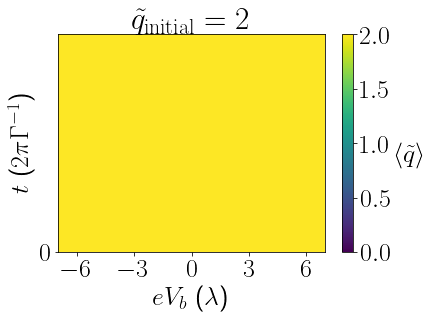

In [121]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=2$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab, qarr2.T, vmin=0, vmax=2)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$\langle \tilde{q} \rangle$', labelpad=20, loc='center',rotation=0)
plt.show()

In [122]:
Jarr2=np.array(Jtab2)
Itab2=[]
for k in range(NV+1):
    I=[]
    vol=-Vmax+k*2*Vmax/NV
    for i in range(Navg, Nlong):
        curr=1e12*1.6e-19*(Jarr2[k,i]-Jarr2[k,i-Navg])/(tb*1e-6)
        I.append(curr)
    Itab2.append(I)
    
Iarr2=np.array(Itab2)

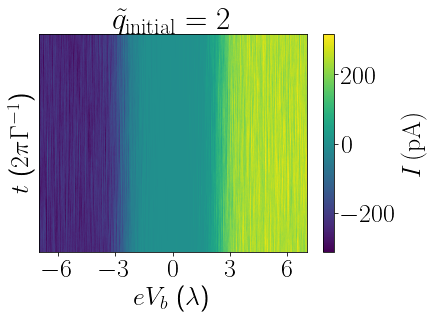

In [123]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$t$ ($2\pi\Gamma^{-1}$)')
ax.set_title(r'$\tilde{q}_{\rm initial}=2$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([0,500*tGam,1000*tGam,2000*tGam]), labels=['$0$', '$500$', '$1000$','$2000$'])
plt.pcolormesh(vtab, ttab_red, Iarr2.T)
cbar=plt.colorbar(location='right')
cbar.set_label(r'$I\, (\rm pA)$')
plt.show()

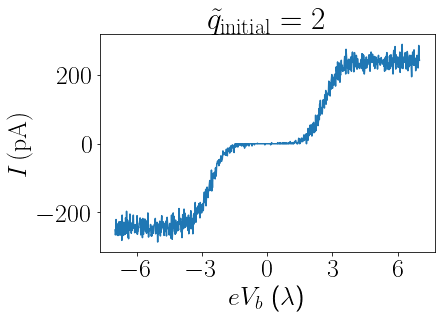

In [124]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$I\, (\rm pA)$')
ax.set_title(r'$\tilde{q}_{\rm initial}=2$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
plt.plot(vtab,Iarr2[:,-1])
plt.show()

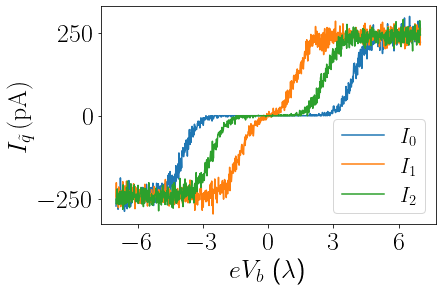

In [137]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$eV_b$ ($\lambda$)')
ax.set_ylabel(r'$I_{\tilde{q}}\, (\rm pA)$')
ax.set_xticks(np.array([-6*lam,-3*lam,0,3*lam,6*lam]), labels=['$-6$','$-3$', '$0$', '$3$','$6$'])
ax.set_yticks(np.array([-250,0,250]))
plt.plot(vtab,Iarr0[:,-1],label=r'$I_0$')
plt.plot(vtab,Iarr1[:,-1],label=r'$I_1$')
plt.plot(vtab,Iarr2[:,-1],label=r'$I_2$')
plt.legend(loc='lower right',prop={'size':21})
plt.show()

In [135]:
vtab[617]/lam

2.5977777777777766

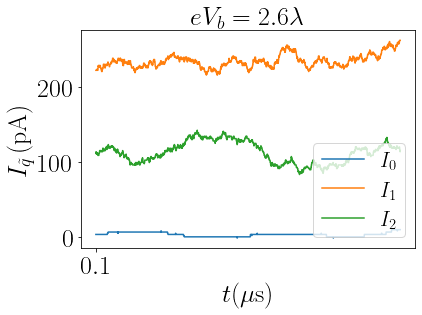

In [139]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I_{\tilde{q}}\, (\rm pA)$')
ax.set_title(r'$eV_b=2.6\lambda$',fontsize=26)
ax.set_xticks(np.array([tb,500*tres,1000*tres]), labels=['$0.1$','$5$','$10$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.plot(ttab_red,Iarr0[617,:],label=r'$I_0$')
plt.plot(ttab_red,Iarr1[617,:],label=r'$I_1$')
plt.plot(ttab_red,Iarr2[617,:],label=r'$I_2$')
plt.legend(loc='lower right',prop={'size':21})
plt.show()